### 초기 경로 설정 (클래스 이용을 위함)

In [1]:
%cd /project/segmentation/smcho1201/segmentation_project

/project/segmentation/smcho1201/segmentation_project


In [2]:
# files and system
import os
import sys
import time
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from IPython.display import clear_output
# working with images
import cv2
import imageio
import scipy.ndimage
# import skimage.transform

import torchvision.transforms as transforms

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


import torchsummary
from tqdm import notebook

sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss, DiceBCELoss , dice_pytorch_eval
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet

## 랜덤성을 배제한 환경 고정

In [3]:
random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [4]:
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda:1


# 1. Image augentation
> 실험할 때는 아예 augmentation도 고정시켜서 저장한 이미지를 사용해야 함.

In [5]:
_size = 224, 224
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


# 2. 데이터셋 클래스 생성
> 해당 클래스는 이용하려는 이미지와 라벨의 모든 경로(/data/segmentation/...)의 리스트를 인자로 받는다.   

In [6]:
train_images = glob.glob('/data/segmentation/wound/trainset/images/*')
train_labels = glob.glob('/data/segmentation/wound/trainset/labels/*')
train_images = [img for img in train_images if img.find('jpg')!= -1] # super pixels 이미지 제외

valid_images = glob.glob('/data/segmentation/wound/validationset/images/*')
valid_labels = glob.glob('/data/segmentation/wound/validationset/labels/*')
valid_images = [img for img in valid_images if img.find('jpg')!= -1] # super pixels 이미지 제외

train_images = sorted(train_images)
train_labels = sorted(train_labels)

valid_images = sorted(valid_images)
valid_labels = sorted(valid_labels)

# 데이터셋 클래스 적용
custom_dataset_train = myDataSet(train_images, train_labels, transforms=test_transforms)
print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))

custom_dataset_val = myDataSet(valid_images, valid_labels, transforms=test_transforms)
print("My custom valing-dataset has {} elements".format(len(custom_dataset_val)))

My custom training-dataset has 553 elements
My custom valing-dataset has 278 elements


### dataset class check
> RGB 채널 평균 값이라 색 바뀜

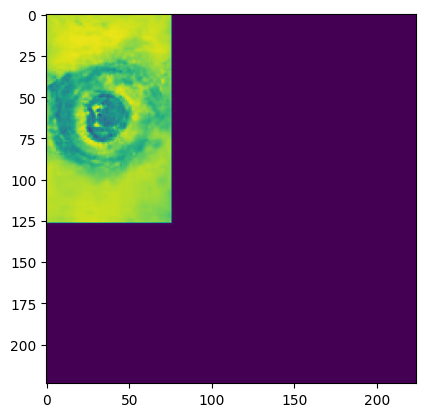

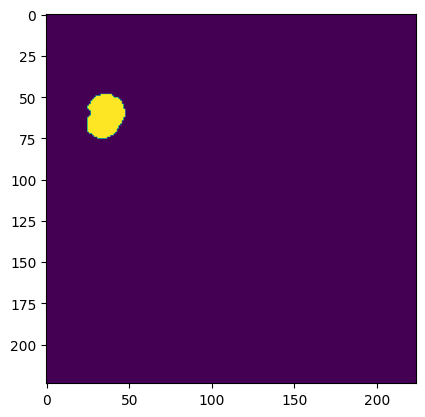

3픽셀의 평균값이라 색깔이 변경됨.


In [7]:
# Show example images.
image_number = 23
img, mask = custom_dataset_train.__getitem__(image_number)

# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()
print('3픽셀의 평균값이라 색깔이 변경됨.')

# 3. 모델 클래스 생성

In [8]:
# Begin training
from models.nnUNet.nnunet import Nested_UNet as UNet_2p
model = UNet_2p(1,3)
model = model.to(DEVICE) # load model to DEVICE

# 4. 하이퍼 파라미터 세팅 & 데이터 로더 생성

In [9]:
# Define variables for the training
epochs = 100
patience = 20
BATCH_SIZE = 8

dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [10]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

criterion = DiceBCELoss()
model_name = 'UNet++'
data_name = 'wound'

# 5. Training

/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 Epoch: 1 of 100, Iter.: 70 of 70, Train Loss: 1.327467, IoU: 0.446211, Dice: 0.573813
 Epoch: 1 of 100, Iter.: 70 of 70, Valid Loss: 1.252424, IoU: 0.522296, Dice: 0.644410

시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.


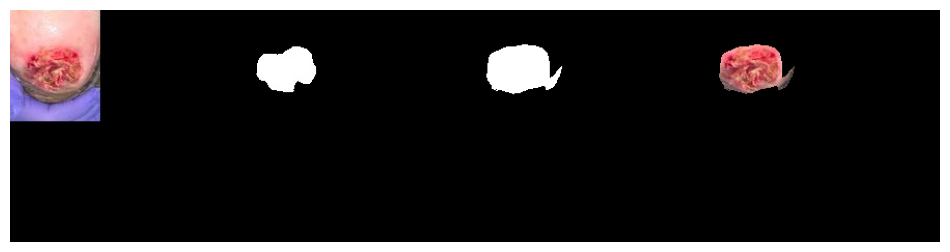

 Epoch: 2 of 100, Iter.: 70 of 70, Train Loss: 1.239346, IoU: 0.540673, Dice: 0.666099
 Epoch: 2 of 100, Iter.: 70 of 70, Valid Loss: 1.214071, IoU: 0.579955, Dice: 0.708011


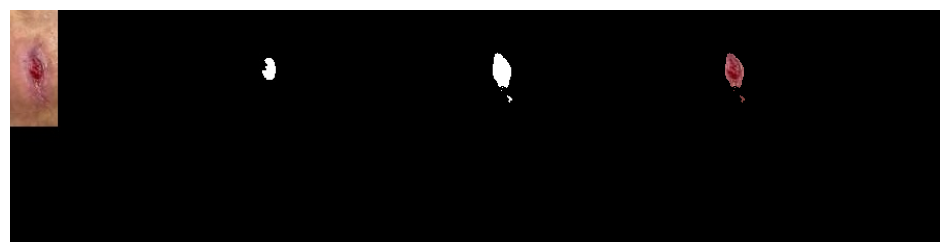

 Epoch: 3 of 100, Iter.: 70 of 70, Train Loss: 1.200670, IoU: 0.551793, Dice: 0.677304
 Epoch: 3 of 100, Iter.: 70 of 70, Valid Loss: 1.185676, IoU: 0.600429, Dice: 0.722425


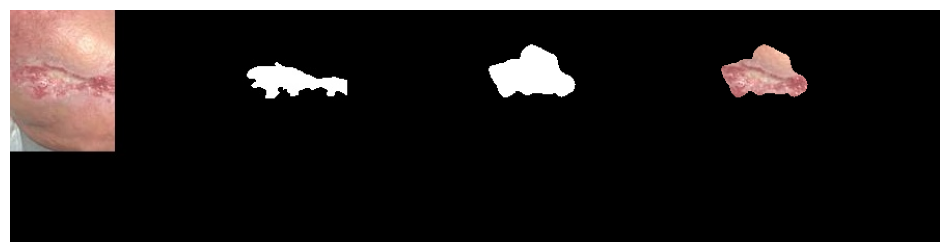

 Epoch: 4 of 100, Iter.: 70 of 70, Train Loss: 1.165334, IoU: 0.574984, Dice: 0.701902
 Epoch: 4 of 100, Iter.: 70 of 70, Valid Loss: 1.152072, IoU: 0.563544, Dice: 0.693235


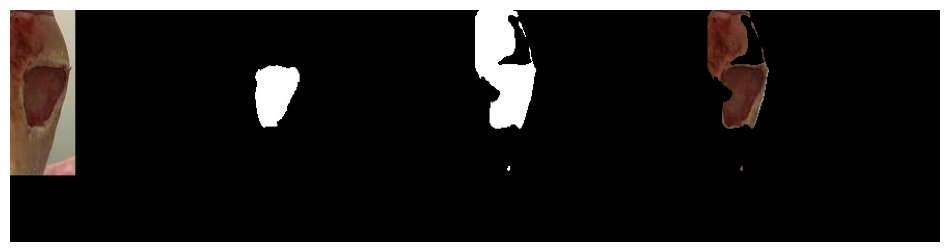

 Epoch: 5 of 100, Iter.: 70 of 70, Train Loss: 1.138926, IoU: 0.572603, Dice: 0.693031
 Epoch: 5 of 100, Iter.: 70 of 70, Valid Loss: 1.124856, IoU: 0.609816, Dice: 0.724818


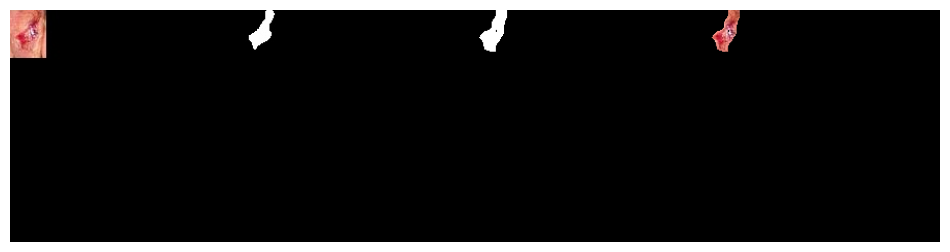

 Epoch: 6 of 100, Iter.: 70 of 70, Train Loss: 1.102151, IoU: 0.606125, Dice: 0.723641
 Epoch: 6 of 100, Iter.: 70 of 70, Valid Loss: 1.163008, IoU: 0.405555, Dice: 0.547834


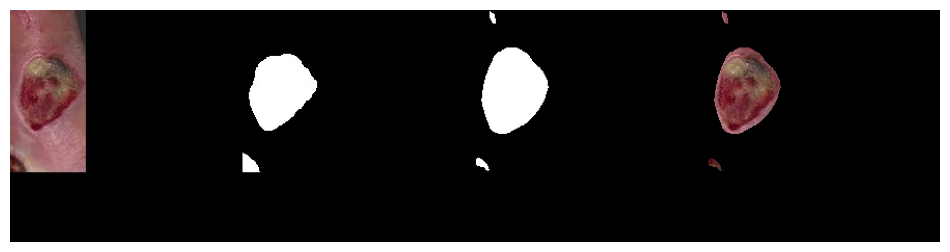

 Epoch: 7 of 100, Iter.: 70 of 70, Train Loss: 1.076740, IoU: 0.594307, Dice: 0.712504
 Epoch: 7 of 100, Iter.: 70 of 70, Valid Loss: 1.051886, IoU: 0.627035, Dice: 0.746278


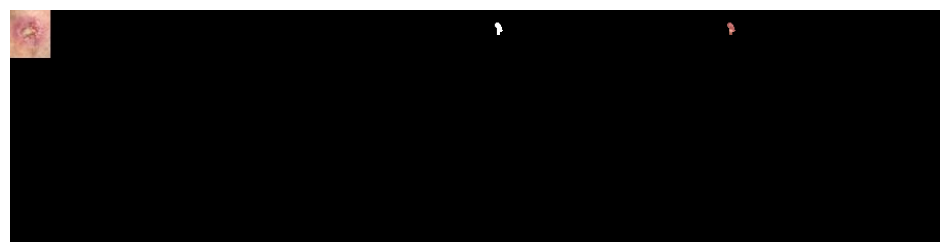

 Epoch: 8 of 100, Iter.: 70 of 70, Train Loss: 1.046102, IoU: 0.618649, Dice: 0.732643
 Epoch: 8 of 100, Iter.: 70 of 70, Valid Loss: 1.046765, IoU: 0.623528, Dice: 0.738030


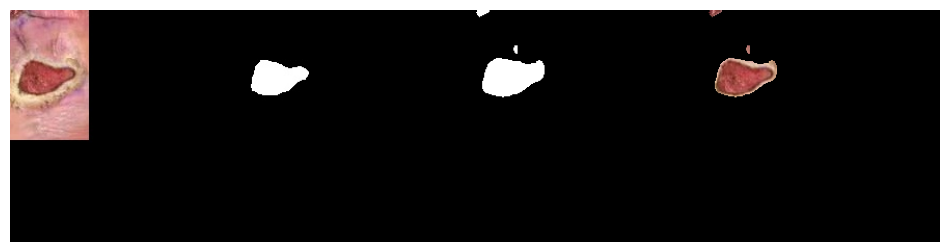

 Epoch: 9 of 100, Iter.: 70 of 70, Train Loss: 1.016813, IoU: 0.626836, Dice: 0.738994
 Epoch: 9 of 100, Iter.: 70 of 70, Valid Loss: 1.022623, IoU: 0.626615, Dice: 0.741358


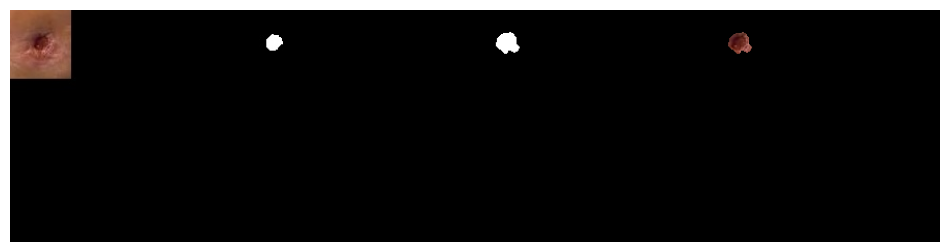

 Epoch: 10 of 100, Iter.: 70 of 70, Train Loss: 0.993794, IoU: 0.618727, Dice: 0.727038
 Epoch: 10 of 100, Iter.: 70 of 70, Valid Loss: 0.996122, IoU: 0.673490, Dice: 0.779399


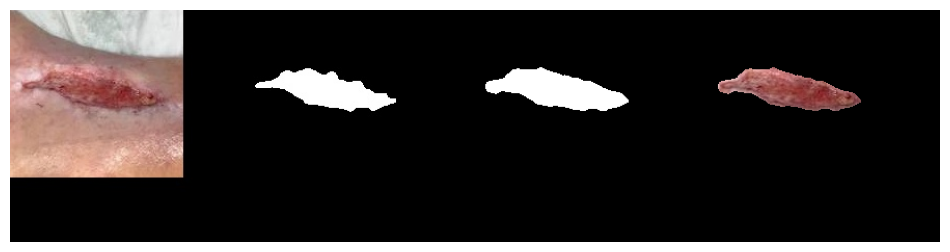

 Epoch: 11 of 100, Iter.: 70 of 70, Train Loss: 0.961749, IoU: 0.635940, Dice: 0.743241
 Epoch: 11 of 100, Iter.: 70 of 70, Valid Loss: 0.936902, IoU: 0.634188, Dice: 0.746958


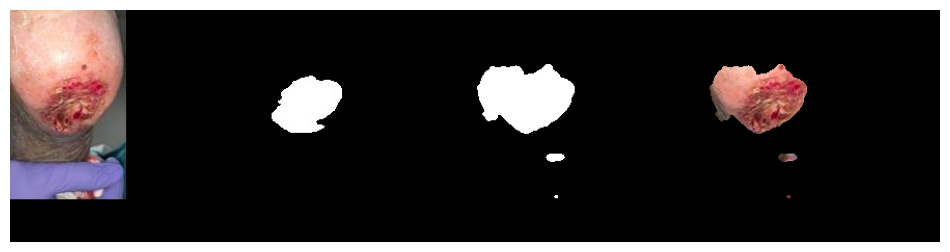

 Epoch: 12 of 100, Iter.: 70 of 70, Train Loss: 0.926522, IoU: 0.659027, Dice: 0.768482
 Epoch: 12 of 100, Iter.: 70 of 70, Valid Loss: 0.979714, IoU: 0.583176, Dice: 0.706297


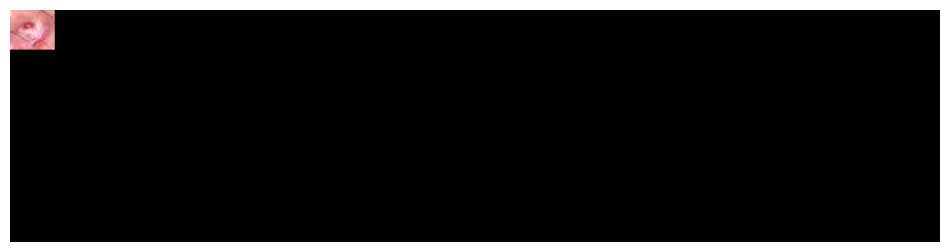

 Epoch: 13 of 100, Iter.: 70 of 70, Train Loss: 0.906788, IoU: 0.645325, Dice: 0.755737
 Epoch: 13 of 100, Iter.: 70 of 70, Valid Loss: 0.894379, IoU: 0.668048, Dice: 0.782588


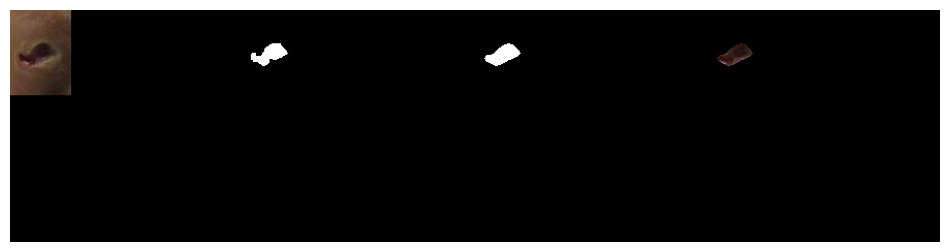

 Epoch: 14 of 100, Iter.: 70 of 70, Train Loss: 0.874266, IoU: 0.664791, Dice: 0.772367
 Epoch: 14 of 100, Iter.: 70 of 70, Valid Loss: 0.869345, IoU: 0.619603, Dice: 0.740474


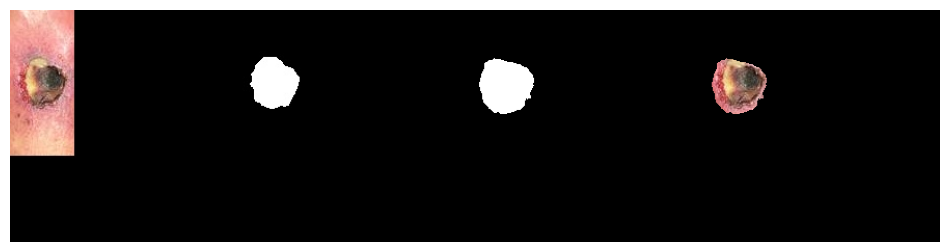

 Epoch: 15 of 100, Iter.: 70 of 70, Train Loss: 0.847554, IoU: 0.676424, Dice: 0.778728
 Epoch: 15 of 100, Iter.: 70 of 70, Valid Loss: 0.856748, IoU: 0.666865, Dice: 0.774411


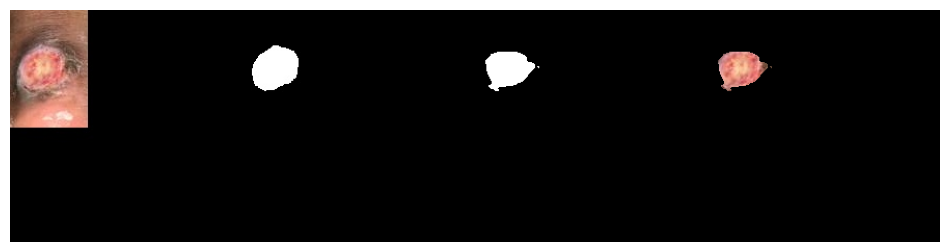

 Epoch: 16 of 100, Iter.: 70 of 70, Train Loss: 0.809004, IoU: 0.699741, Dice: 0.809552
 Epoch: 16 of 100, Iter.: 70 of 70, Valid Loss: 0.805021, IoU: 0.691148, Dice: 0.791913


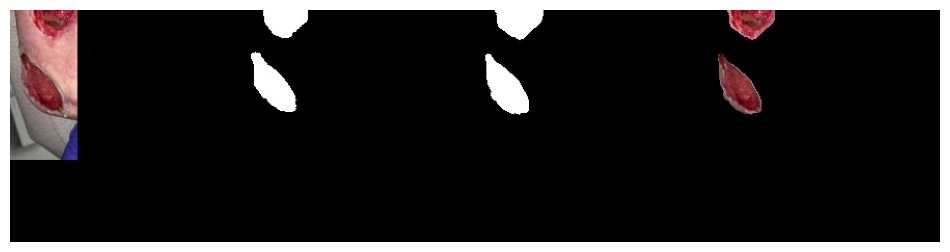

 Epoch: 17 of 100, Iter.: 70 of 70, Train Loss: 0.781916, IoU: 0.702433, Dice: 0.803391
 Epoch: 17 of 100, Iter.: 70 of 70, Valid Loss: 0.788264, IoU: 0.661584, Dice: 0.777944


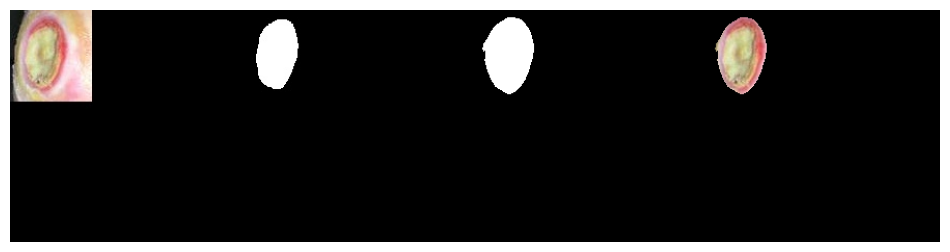

 Epoch: 18 of 100, Iter.: 70 of 70, Train Loss: 0.757722, IoU: 0.706702, Dice: 0.810726
 Epoch: 18 of 100, Iter.: 70 of 70, Valid Loss: 0.766651, IoU: 0.655520, Dice: 0.769967


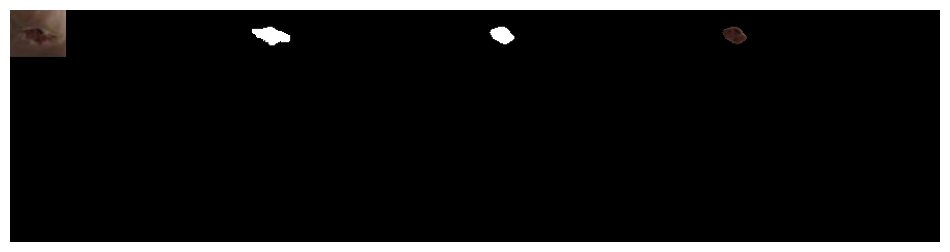

 Epoch: 19 of 100, Iter.: 70 of 70, Train Loss: 0.723638, IoU: 0.704536, Dice: 0.804074
 Epoch: 19 of 100, Iter.: 70 of 70, Valid Loss: 0.765453, IoU: 0.687816, Dice: 0.786343


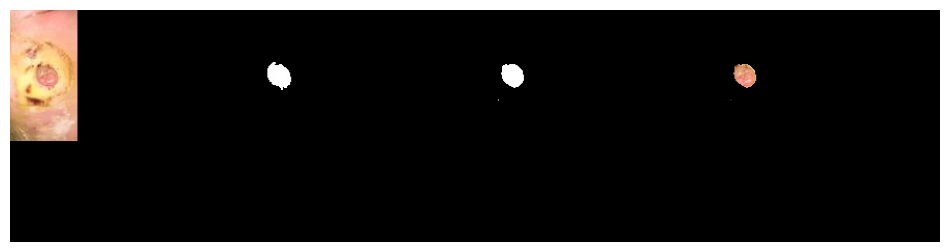

 Epoch: 20 of 100, Iter.: 70 of 70, Train Loss: 0.694375, IoU: 0.721043, Dice: 0.823611
 Epoch: 20 of 100, Iter.: 70 of 70, Valid Loss: 0.708720, IoU: 0.692523, Dice: 0.802465


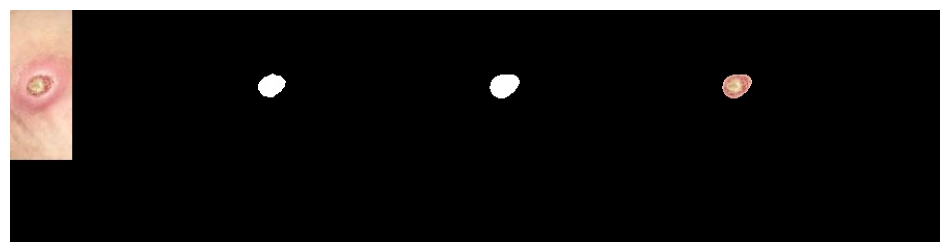

 Epoch: 21 of 100, Iter.: 70 of 70, Train Loss: 0.654307, IoU: 0.734660, Dice: 0.828031
 Epoch: 21 of 100, Iter.: 70 of 70, Valid Loss: 0.684266, IoU: 0.658432, Dice: 0.773821


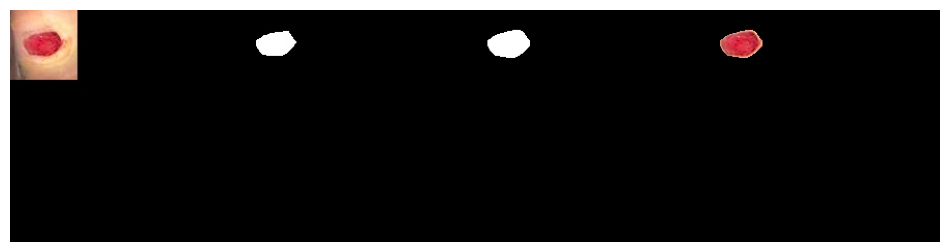

 Epoch: 22 of 100, Iter.: 70 of 70, Train Loss: 0.639086, IoU: 0.708053, Dice: 0.810261
 Epoch: 22 of 100, Iter.: 70 of 70, Valid Loss: 0.662973, IoU: 0.680589, Dice: 0.776034


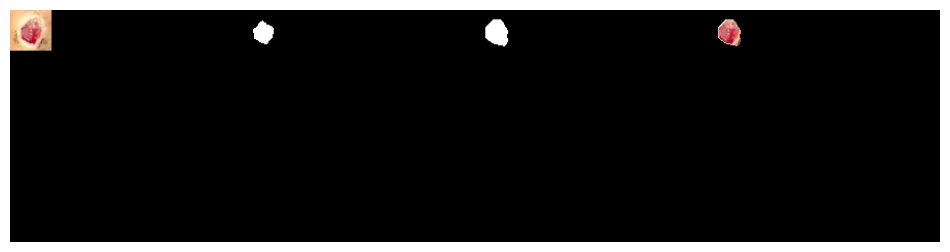

 Epoch: 23 of 100, Iter.: 70 of 70, Train Loss: 0.594399, IoU: 0.741686, Dice: 0.840878
 Epoch: 23 of 100, Iter.: 70 of 70, Valid Loss: 0.622384, IoU: 0.708010, Dice: 0.820753


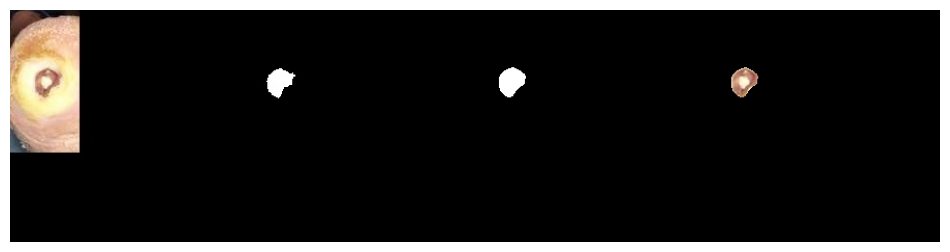

 Epoch: 24 of 100, Iter.: 70 of 70, Train Loss: 0.581648, IoU: 0.735204, Dice: 0.835375
 Epoch: 24 of 100, Iter.: 70 of 70, Valid Loss: 0.584864, IoU: 0.677785, Dice: 0.776724


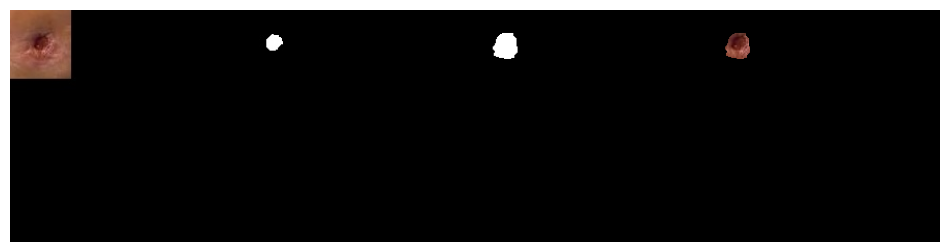

 Epoch: 25 of 100, Iter.: 70 of 70, Train Loss: 0.540989, IoU: 0.754759, Dice: 0.855190
 Epoch: 25 of 100, Iter.: 70 of 70, Valid Loss: 0.560870, IoU: 0.704088, Dice: 0.800868


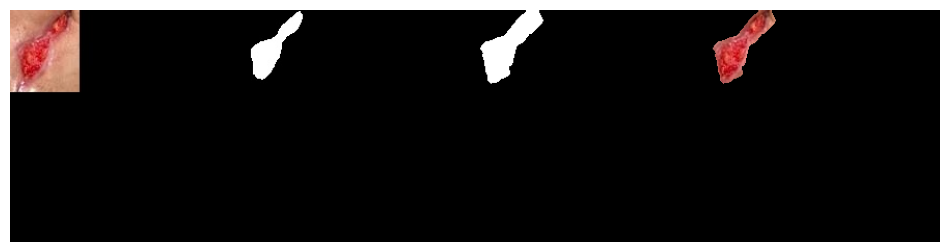

 Epoch: 26 of 100, Iter.: 70 of 70, Train Loss: 0.508747, IoU: 0.770921, Dice: 0.872493
 Epoch: 26 of 100, Iter.: 70 of 70, Valid Loss: 0.540702, IoU: 0.718706, Dice: 0.816160


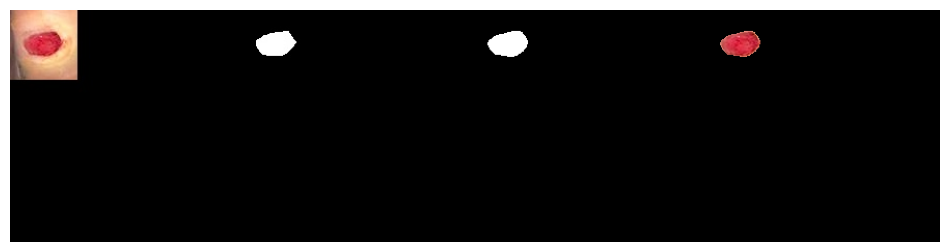

 Epoch: 27 of 100, Iter.: 70 of 70, Train Loss: 0.491777, IoU: 0.755514, Dice: 0.851283
 Epoch: 27 of 100, Iter.: 70 of 70, Valid Loss: 0.541253, IoU: 0.679171, Dice: 0.797450


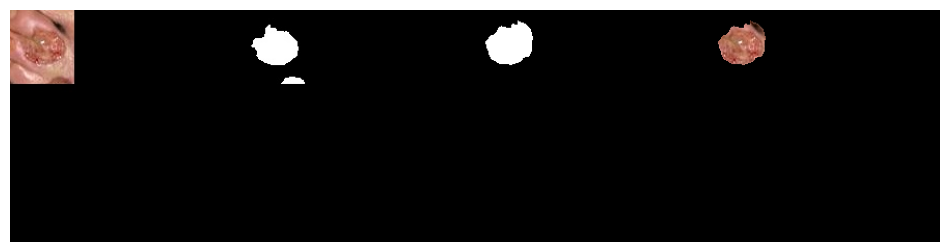

 Epoch: 28 of 100, Iter.: 70 of 70, Train Loss: 0.455967, IoU: 0.769080, Dice: 0.866668
 Epoch: 28 of 100, Iter.: 70 of 70, Valid Loss: 0.477941, IoU: 0.698540, Dice: 0.793064


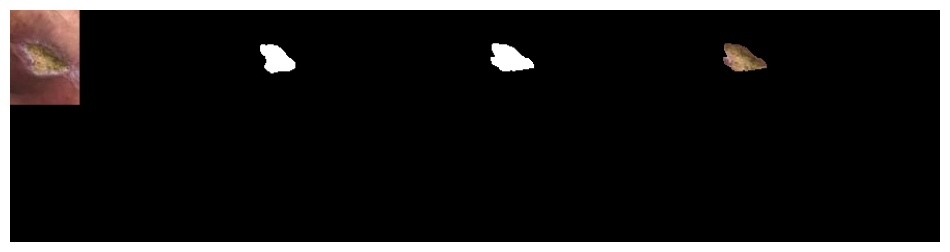

 Epoch: 29 of 100, Iter.: 70 of 70, Train Loss: 0.423467, IoU: 0.790308, Dice: 0.888318
 Epoch: 29 of 100, Iter.: 70 of 70, Valid Loss: 0.463994, IoU: 0.708234, Dice: 0.818441


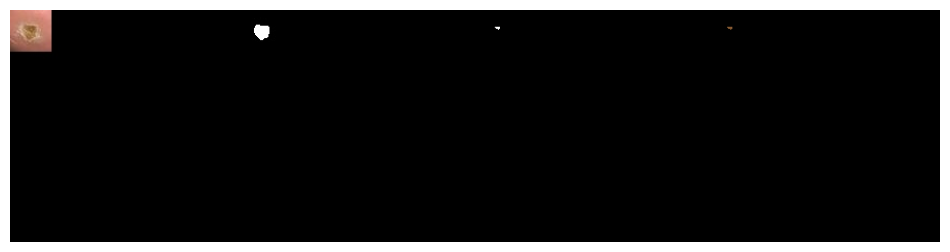

 Epoch: 30 of 100, Iter.: 70 of 70, Train Loss: 0.395144, IoU: 0.798745, Dice: 0.894868
 Epoch: 30 of 100, Iter.: 70 of 70, Valid Loss: 0.438022, IoU: 0.717565, Dice: 0.812149


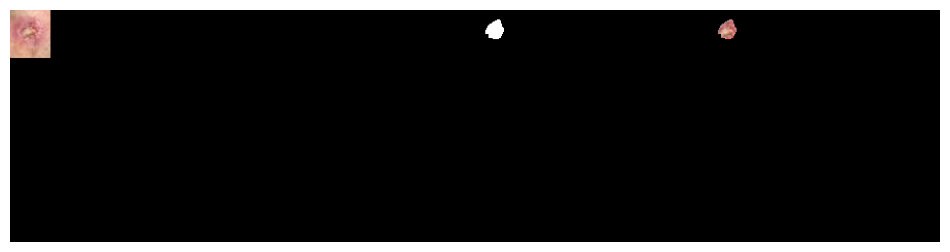

 Epoch: 31 of 100, Iter.: 70 of 70, Train Loss: 0.373543, IoU: 0.797926, Dice: 0.896085
 Epoch: 31 of 100, Iter.: 70 of 70, Valid Loss: 0.409643, IoU: 0.733982, Dice: 0.828396


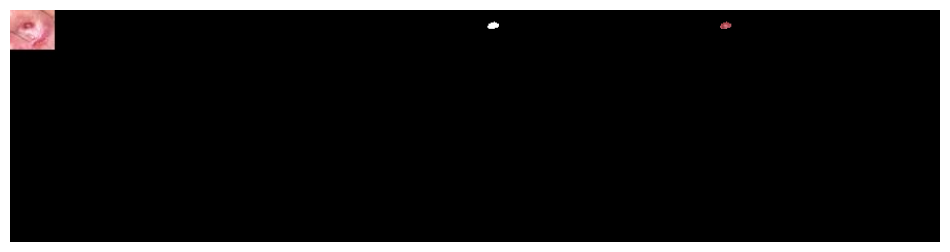

 Epoch: 32 of 100, Iter.: 70 of 70, Train Loss: 0.346387, IoU: 0.803311, Dice: 0.899263
 Epoch: 32 of 100, Iter.: 70 of 70, Valid Loss: 0.400586, IoU: 0.708603, Dice: 0.822594


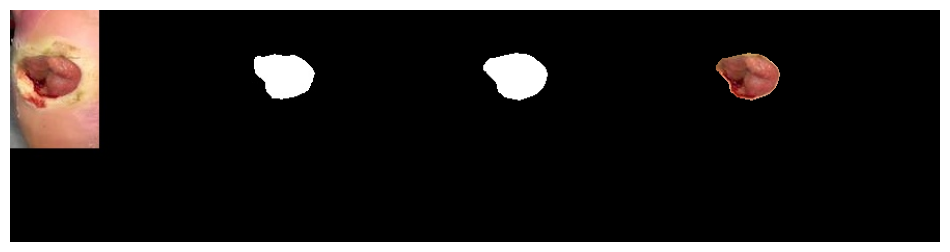

 Epoch: 33 of 100, Iter.: 70 of 70, Train Loss: 0.324569, IoU: 0.811399, Dice: 0.909931
 Epoch: 33 of 100, Iter.: 70 of 70, Valid Loss: 0.373034, IoU: 0.714666, Dice: 0.808908


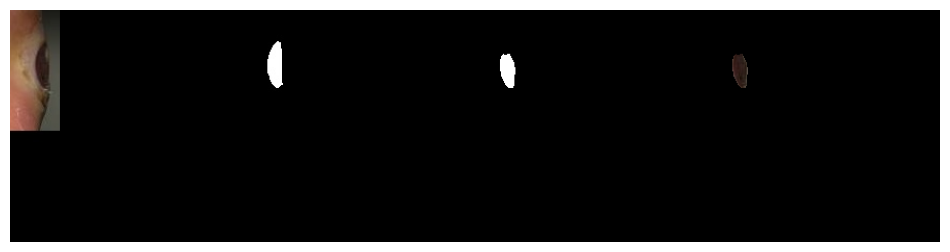

 Epoch: 34 of 100, Iter.: 70 of 70, Train Loss: 0.321243, IoU: 0.790129, Dice: 0.887126
 Epoch: 34 of 100, Iter.: 70 of 70, Valid Loss: 0.629094, IoU: 0.526169, Dice: 0.641281


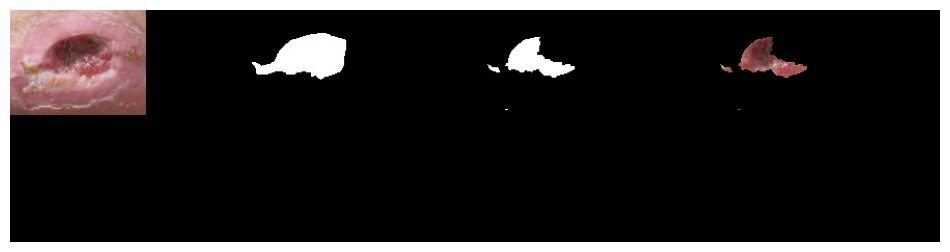

 Epoch: 35 of 100, Iter.: 70 of 70, Train Loss: 0.343074, IoU: 0.717473, Dice: 0.819210
 Epoch: 35 of 100, Iter.: 70 of 70, Valid Loss: 0.358517, IoU: 0.684842, Dice: 0.803477


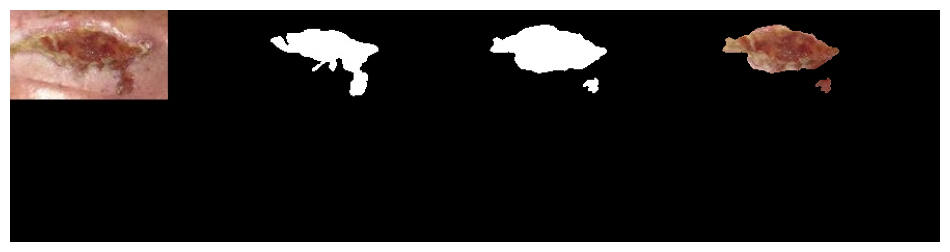

 Epoch: 36 of 100, Iter.: 70 of 70, Train Loss: 0.298738, IoU: 0.762557, Dice: 0.862908
 Epoch: 36 of 100, Iter.: 70 of 70, Valid Loss: 0.356564, IoU: 0.693145, Dice: 0.800956


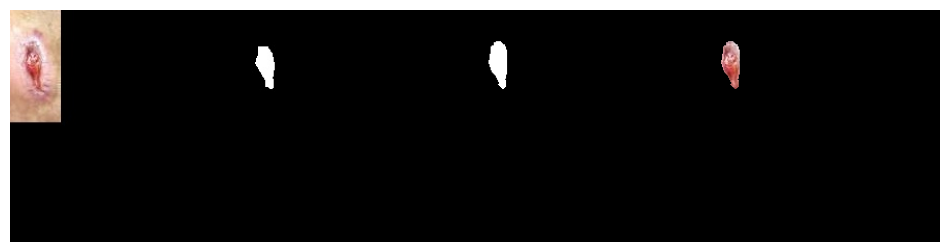

 Epoch: 37 of 100, Iter.: 70 of 70, Train Loss: 0.271073, IoU: 0.771942, Dice: 0.864478
 Epoch: 37 of 100, Iter.: 70 of 70, Valid Loss: 0.363144, IoU: 0.683079, Dice: 0.798478


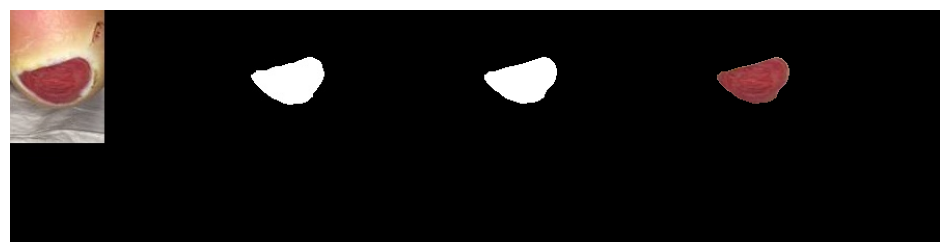

 Epoch: 38 of 100, Iter.: 70 of 70, Train Loss: 0.248921, IoU: 0.804923, Dice: 0.905849
 Epoch: 38 of 100, Iter.: 70 of 70, Valid Loss: 0.302919, IoU: 0.730867, Dice: 0.838877


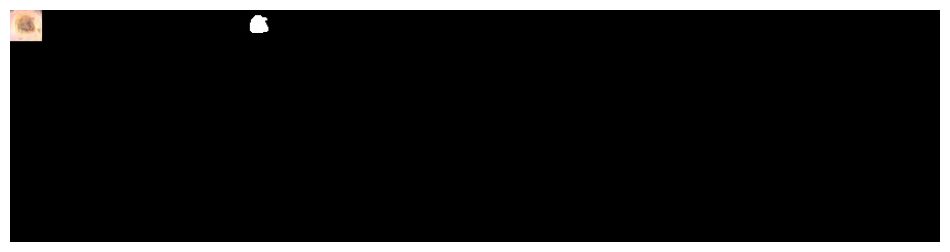

 Epoch: 39 of 100, Iter.: 70 of 70, Train Loss: 0.233315, IoU: 0.816593, Dice: 0.915609
 Epoch: 39 of 100, Iter.: 70 of 70, Valid Loss: 0.305447, IoU: 0.703349, Dice: 0.801043


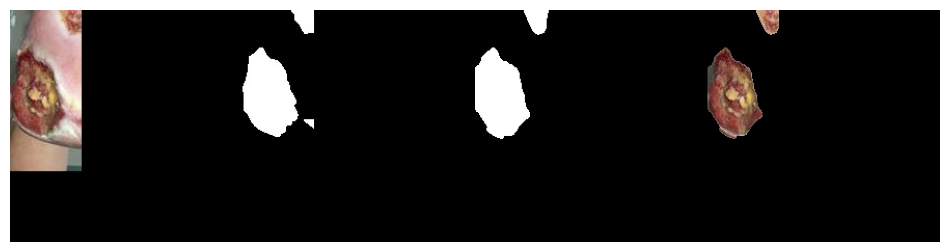

 Epoch: 40 of 100, Iter.: 70 of 70, Train Loss: 0.273314, IoU: 0.732520, Dice: 0.830640
 Epoch: 40 of 100, Iter.: 70 of 70, Valid Loss: 0.312130, IoU: 0.701037, Dice: 0.805713


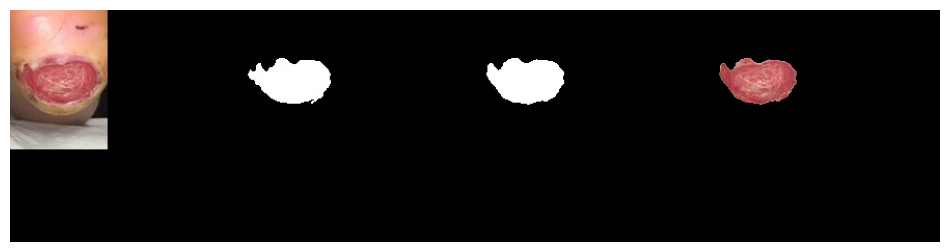

 Epoch: 41 of 100, Iter.: 70 of 70, Train Loss: 0.225221, IoU: 0.794329, Dice: 0.891278
 Epoch: 41 of 100, Iter.: 70 of 70, Valid Loss: 0.287080, IoU: 0.709786, Dice: 0.816741


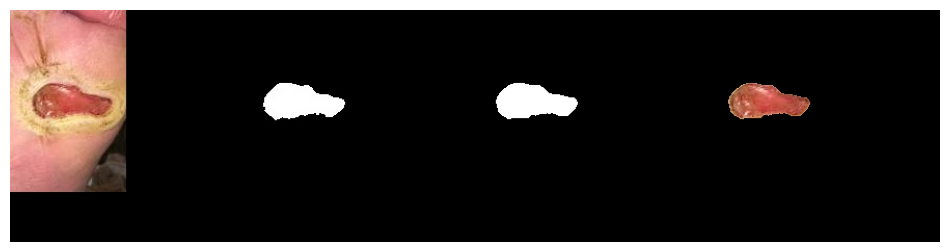

 Epoch: 42 of 100, Iter.: 70 of 70, Train Loss: 0.197971, IoU: 0.831451, Dice: 0.934096
 Epoch: 42 of 100, Iter.: 70 of 70, Valid Loss: 0.260641, IoU: 0.724626, Dice: 0.821727


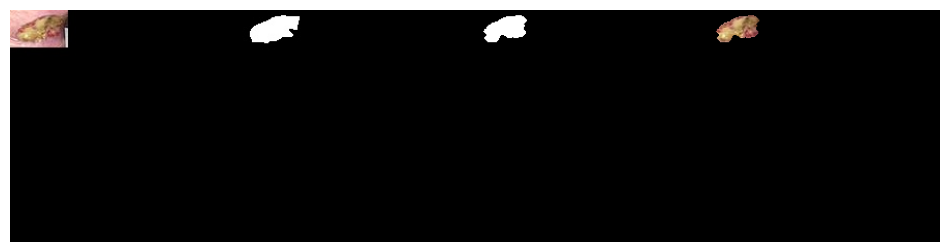

 Epoch: 43 of 100, Iter.: 70 of 70, Train Loss: 0.187778, IoU: 0.839545, Dice: 0.942066
 Epoch: 43 of 100, Iter.: 70 of 70, Valid Loss: 0.262217, IoU: 0.722297, Dice: 0.820007


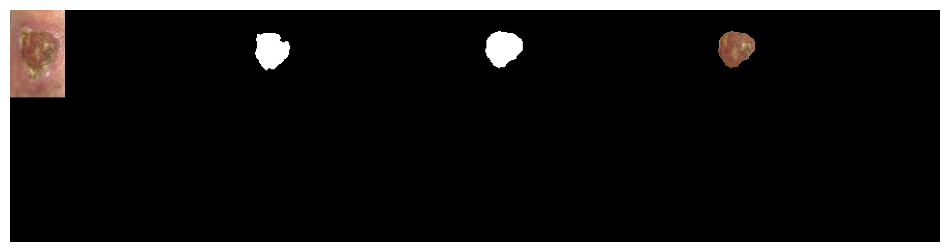

 Epoch: 44 of 100, Iter.: 70 of 70, Train Loss: 0.171886, IoU: 0.853367, Dice: 0.957083
 Epoch: 44 of 100, Iter.: 70 of 70, Valid Loss: 0.247556, IoU: 0.728819, Dice: 0.831989


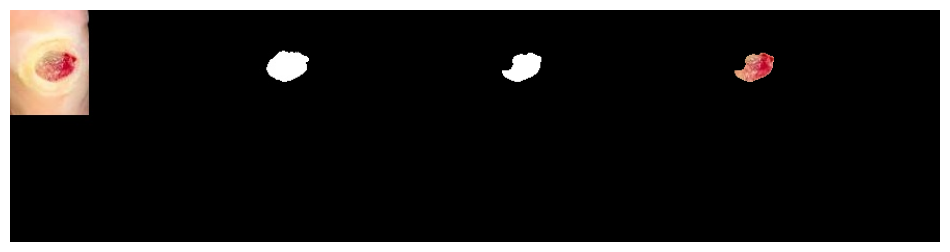

 Epoch: 45 of 100, Iter.: 70 of 70, Train Loss: 0.175457, IoU: 0.850222, Dice: 0.948700
 Epoch: 45 of 100, Iter.: 70 of 70, Valid Loss: 0.244669, IoU: 0.717784, Dice: 0.819075


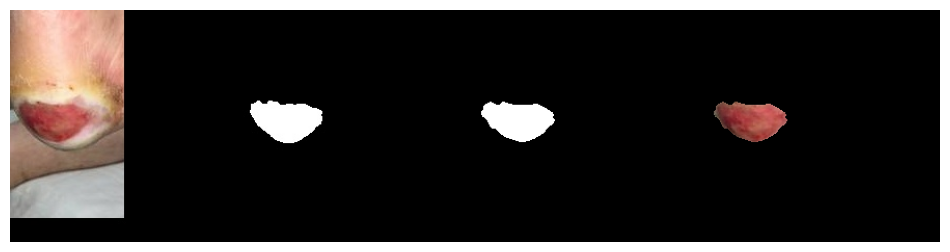

 Epoch: 46 of 100, Iter.: 70 of 70, Train Loss: 0.171707, IoU: 0.834652, Dice: 0.929458
 Epoch: 46 of 100, Iter.: 70 of 70, Valid Loss: 0.234886, IoU: 0.716390, Dice: 0.814416


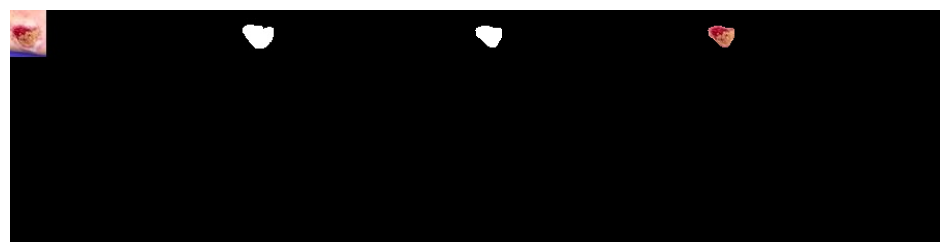

 Epoch: 47 of 100, Iter.: 70 of 70, Train Loss: 0.157732, IoU: 0.843696, Dice: 0.948883
 Epoch: 47 of 100, Iter.: 70 of 70, Valid Loss: 0.232660, IoU: 0.725397, Dice: 0.824496


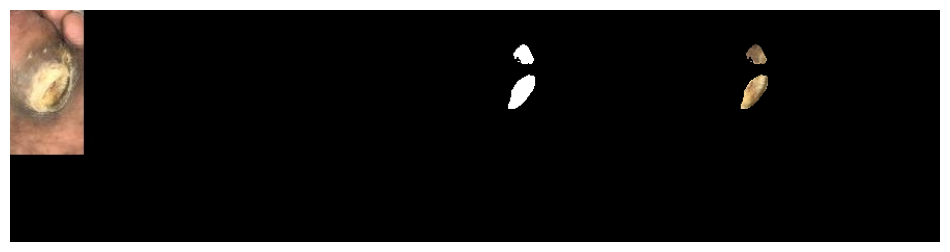

 Epoch: 48 of 100, Iter.: 70 of 70, Train Loss: 0.144421, IoU: 0.856620, Dice: 0.957682
 Epoch: 48 of 100, Iter.: 70 of 70, Valid Loss: 0.234863, IoU: 0.707382, Dice: 0.804654


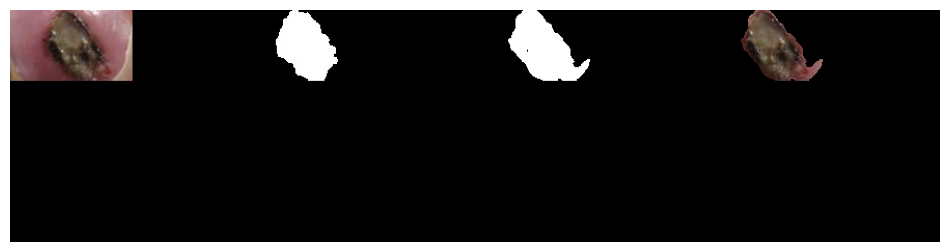

 Epoch: 49 of 100, Iter.: 70 of 70, Train Loss: 0.142320, IoU: 0.855968, Dice: 0.955349
 Epoch: 49 of 100, Iter.: 70 of 70, Valid Loss: 0.298367, IoU: 0.710467, Dice: 0.809844


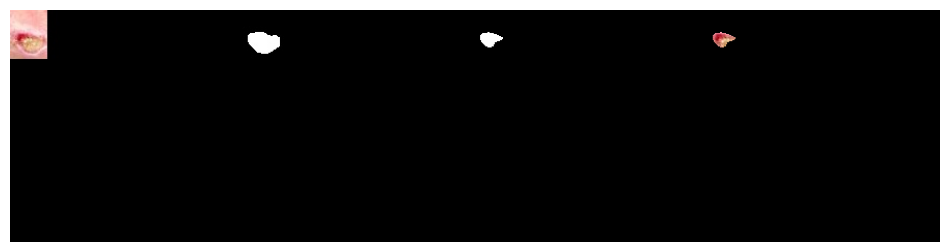

 Epoch: 50 of 100, Iter.: 70 of 70, Train Loss: 0.176011, IoU: 0.784521, Dice: 0.886861
 Epoch: 50 of 100, Iter.: 70 of 70, Valid Loss: 0.263882, IoU: 0.690936, Dice: 0.798533


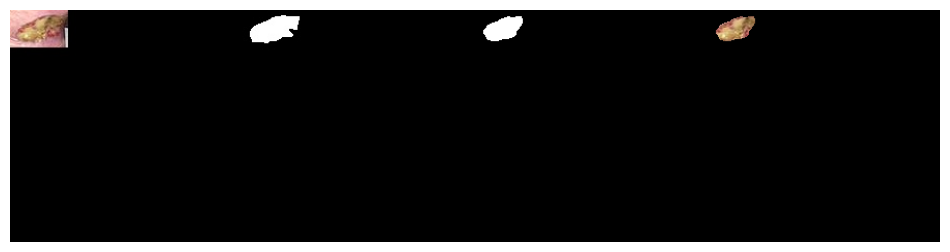

 Epoch: 51 of 100, Iter.: 70 of 70, Train Loss: 0.145790, IoU: 0.829782, Dice: 0.931151
 Epoch: 51 of 100, Iter.: 70 of 70, Valid Loss: 0.234599, IoU: 0.712282, Dice: 0.806914


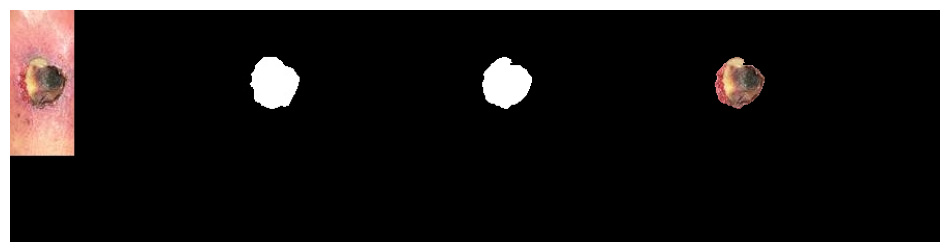

 Epoch: 52 of 100, Iter.: 70 of 70, Train Loss: 0.128837, IoU: 0.840008, Dice: 0.943329
 Epoch: 52 of 100, Iter.: 70 of 70, Valid Loss: 0.219971, IoU: 0.725414, Dice: 0.833182


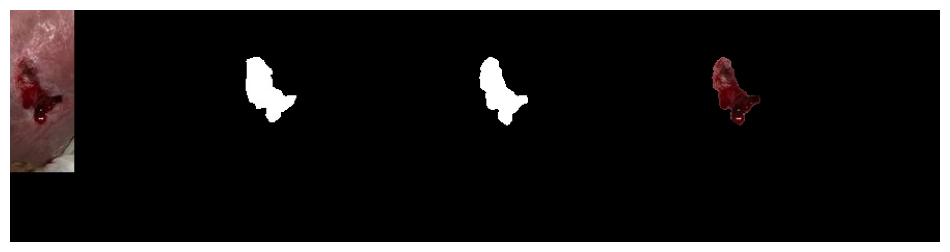

 Epoch: 53 of 100, Iter.: 70 of 70, Train Loss: 0.124029, IoU: 0.863405, Dice: 0.963205
 Epoch: 53 of 100, Iter.: 70 of 70, Valid Loss: 0.203451, IoU: 0.736507, Dice: 0.837184


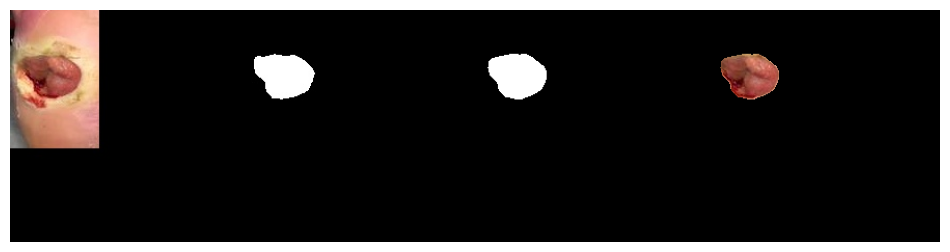

 Epoch: 54 of 100, Iter.: 70 of 70, Train Loss: 0.107651, IoU: 0.882038, Dice: 0.986117
 Epoch: 54 of 100, Iter.: 70 of 70, Valid Loss: 0.212543, IoU: 0.719823, Dice: 0.814669


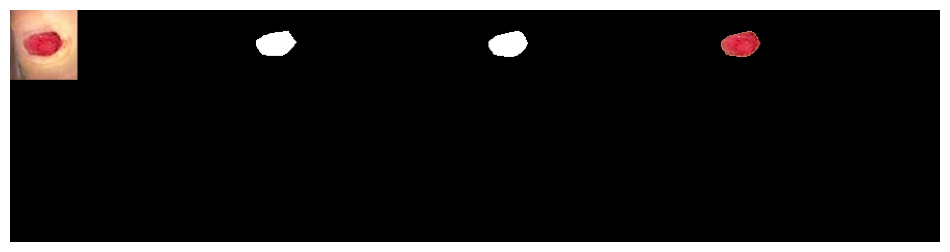

 Epoch: 55 of 100, Iter.: 70 of 70, Train Loss: 0.106406, IoU: 0.878572, Dice: 0.983458
 Epoch: 55 of 100, Iter.: 70 of 70, Valid Loss: 0.208326, IoU: 0.716994, Dice: 0.824901


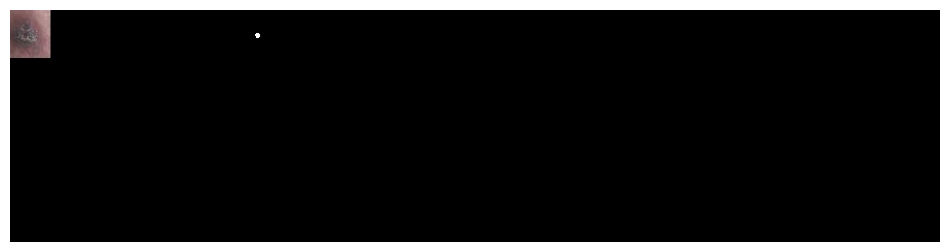

 Epoch: 56 of 100, Iter.: 70 of 70, Train Loss: 0.100185, IoU: 0.887403, Dice: 0.992416
 Epoch: 56 of 100, Iter.: 70 of 70, Valid Loss: 0.212996, IoU: 0.707708, Dice: 0.809828


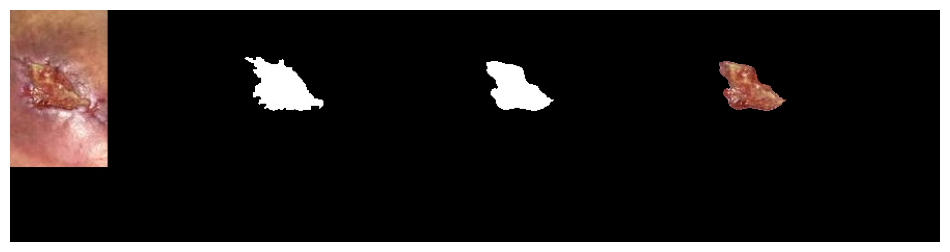

 Epoch: 57 of 100, Iter.: 70 of 70, Train Loss: 0.107668, IoU: 0.876503, Dice: 0.976876
 Epoch: 57 of 100, Iter.: 70 of 70, Valid Loss: 0.204794, IoU: 0.711923, Dice: 0.811879


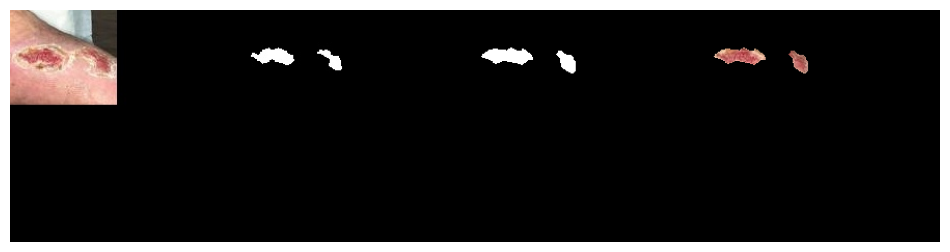

 Epoch: 58 of 100, Iter.: 70 of 70, Train Loss: 0.094435, IoU: 0.889721, Dice: 0.990098
 Epoch: 58 of 100, Iter.: 70 of 70, Valid Loss: 0.201123, IoU: 0.709037, Dice: 0.814490


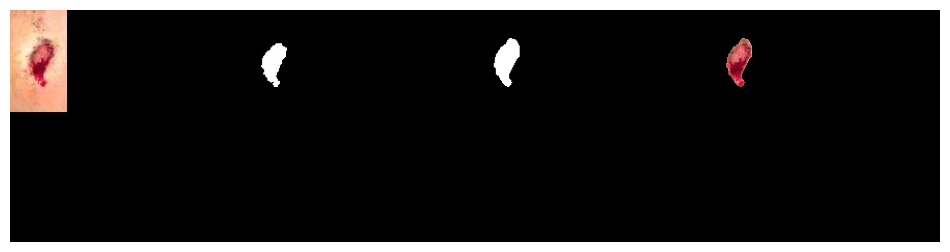

 Epoch: 59 of 100, Iter.: 70 of 70, Train Loss: 0.086554, IoU: 0.896688, Dice: 0.999990
 Epoch: 59 of 100, Iter.: 70 of 70, Valid Loss: 0.191447, IoU: 0.726532, Dice: 0.823805


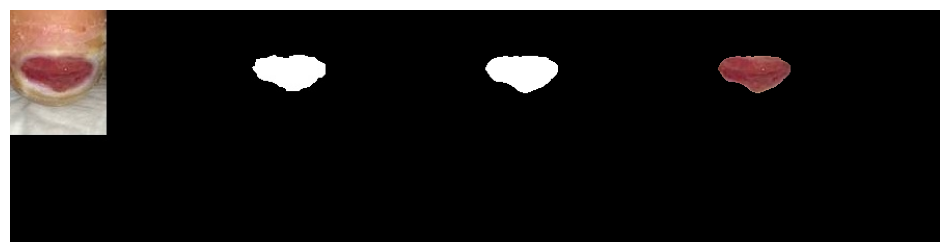


Early stopping. Target criteria has not improved for 20 epochs.

CPU times: user 8min 11s, sys: 7min 8s, total: 15min 20s
Wall time: 11min 43s


In [11]:

%%time
from ploting import plot_model_prediction

train_losses, val_losses = [], []
train_ious, val_ious = [], []
train_dices, val_dices = [], []
best_iou, best_dice, best_loss = 0, 0, np.inf
best_epoch_dice = -1
state = {}
lst_epoch_metric = []

start_time = time.time()
for epoch in range(1, epochs+1):
    running_loss, running_iou, running_dice = 0, 0, 0

    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        
        optimizer.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_iou += iou_pytorch_eval(prediction, masks)
        running_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, IoU:  {:.6f},  Dice:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1), running_iou/(i+1), running_dice/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss, val_iou, val_dice = 0, 0, 0
    for i, (imgs, masks) in enumerate(dataloader_val):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
        val_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_iou/len(dataloader_train), val_iou/(i+1)), end="")

        val_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Dice: {:.6f}, Val. Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_dice/len(dataloader_train), val_dice/(i+1)), end="")
    
    
    # compute overall epoch losses
    epoch_train_loss = running_loss/len(dataloader_train)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = val_loss/len(dataloader_val)
    val_losses.append(epoch_val_loss)

    # compute overall epoch iou-s
    epoch_train_iou = (running_iou/len(dataloader_train)).item()
    train_ious.append(epoch_train_iou)
    epoch_val_iou = (val_iou/len(dataloader_val)).item()
    val_ious.append(epoch_val_iou)
    
    # compute overall epoch dice
    epoch_train_dice = (running_dice/len(dataloader_train)).item()
    train_dices.append(epoch_train_dice)
    epoch_val_dice = (val_dice/len(dataloader_val)).item()
    val_dices.append(epoch_val_dice)

    print("\r Epoch: {} of {}, Iter.: {} of {}, Train Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_train_iou, epoch_train_dice))
    print("\r Epoch: {} of {}, Iter.: {} of {}, Valid Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_val_loss, epoch_val_iou, epoch_val_dice))
    if epoch == 1:
        print('\n시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.')
    plot_model_prediction(model, DEVICE, valid_images, valid_labels)
        
    # plot
    metrics = {'loss':[train_losses, epoch_train_loss, val_losses, epoch_val_loss],
               'Iou':[train_ious, epoch_train_iou, val_ious,  epoch_val_iou],
               'Dice':[train_dices, epoch_train_dice, val_dices,  epoch_val_dice]}
    
    lst_epoch_metric.append([round(epoch_train_loss,4), round(epoch_train_iou,4), round(epoch_train_dice,4), 
                             round(epoch_val_loss,4), round(epoch_val_iou,4), round(epoch_val_dice,4)]) 

    # save if best results or break is has not improved for {patience} number of epochs
    best_iou = max(best_iou, epoch_val_iou)
    best_dice = max(best_dice, epoch_val_dice)
    best_loss = min(best_loss, epoch_val_loss)
    best_epoch_dice = epoch if best_dice == epoch_val_dice else best_epoch_dice

    # record losses
    state['train_losses'] = train_losses
    state['val_losses'] = val_losses
    
    if best_epoch_dice == epoch:
        # print('Saving..')
        state['net'] = model.state_dict()
        state['dice'] = best_dice
        state['epoch'] = epoch
            
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
    
    
    elif best_epoch_dice + patience < epoch:
        print(f"\nEarly stopping. Target criteria has not improved for {patience} epochs.\n")
        break

file_name = f'{model_name}_{data_name}'
# load once more and write all the losses down (othw can miss the last 10)
end_time = time.time() - start_time

state = torch.load(f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
state['train_losses'] = train_losses
state['val_losses'] = val_losses
torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')

df_epoch_metric = pd.DataFrame(lst_epoch_metric, columns = ['epoch_train_loss', 'epoch_val_loss', 'epoch_train_iou', 'epoch_val_iou', 'epoch_train_dice', 'epoch_val_dice'])
df_epoch_metric.to_csv(f'/project/segmentation/smcho1201/training_{model_name}/csv_{file_name}.csv', index_label = ['epoch'])

Validationset 기준 
Best_epoch:38, Best_IOU:0.7365, Best_DiceScore:0.8389


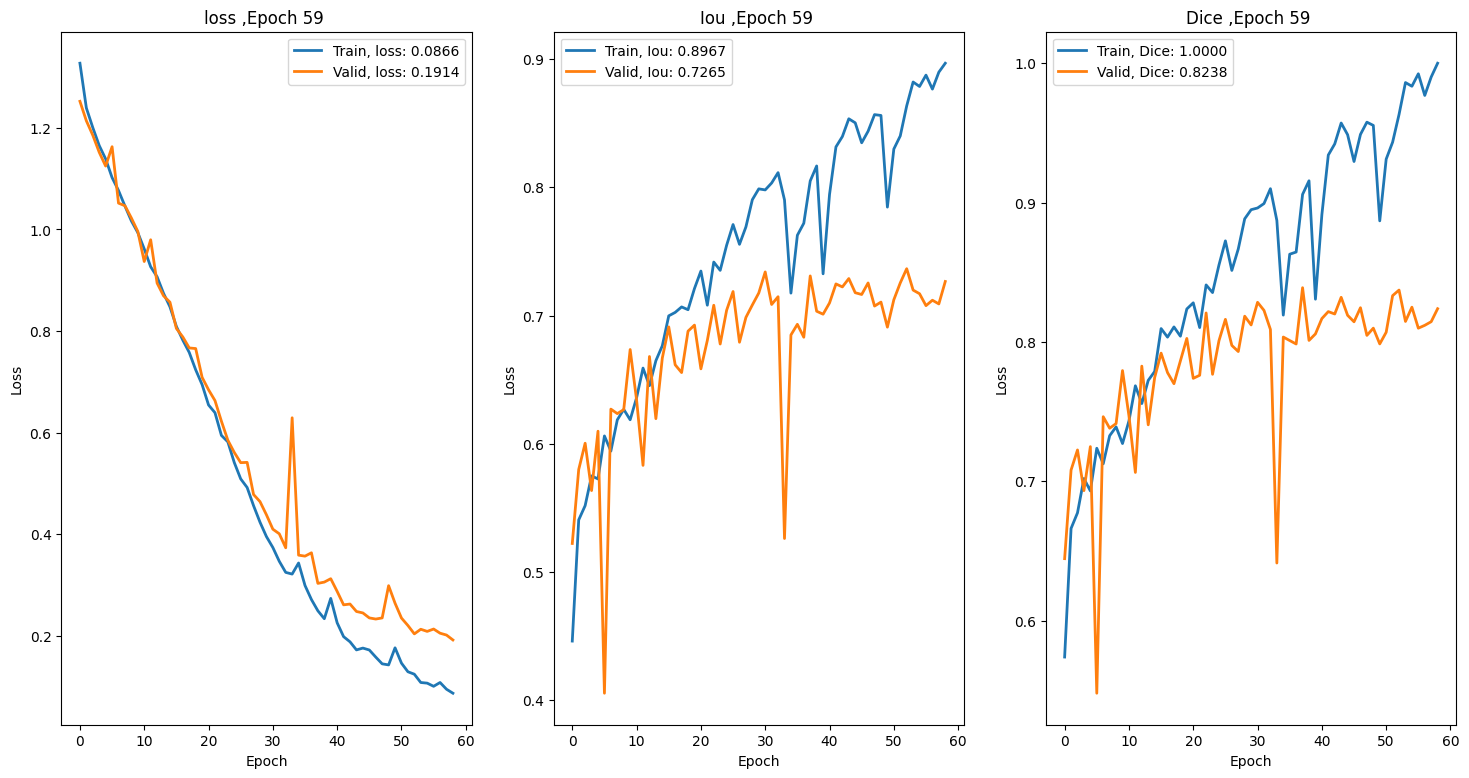

In [12]:
print(f'Validationset 기준 \nBest_epoch:{best_epoch_dice}, Best_IOU:{best_iou:.4f}, Best_DiceScore:{best_dice:.4f}')

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))           
for i, (metric, value) in enumerate(metrics.items()):
    axs[i].plot(np.arange(len(value[0])), value[0], label=f'Train, {metric}: {value[1]:.4f}', linewidth=2)
    axs[i].plot(np.arange(len(value[2])), value[2], label=f'Valid, {metric}: {value[3]:.4f}', linewidth=2)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    axs[i].set_title(f'{metric} ,Epoch {epoch} ')
    axs[i].legend(loc='best')
plt.show()